In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

train = pd.read_csv('compareModel/2021MDPI_CapsNet/train.csv')
val = pd.read_csv('compareModel/2021MDPI_CapsNet/val.csv')
test = pd.read_csv('compareModel/2021MDPI_CapsNet/test.csv')

# to_csv format
train_save = train[['PEP', 'ID']].rename({'PEP':'Seqs',
                                 'ID':'Label'}, axis=1)
train_save.to_csv('compareModel/2021MDPI_CapsNet/train_.csv', index=False)

val_save = val[['PEP', 'ID']].rename({'PEP':'Seqs',
                                 'ID':'Label'}, axis=1)
val_save.to_csv('compareModel/2021MDPI_CapsNet/val_.csv', index=False)

test_save = test[['PEP', 'ID']].rename({'PEP':'Seqs',
                                 'ID':'Label'}, axis=1)
test_save.to_csv('compareModel/2021MDPI_CapsNet/test_.csv', index=False)

(19, 21)


In [2]:
import spacy
import torch
import sys
from torchtext import data, datasets  # .legacy
from torchtext.vocab import Vectors
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.autograd import Variable
import argparse

In [3]:
# parser = argparse.ArgumentParser(description='test')

# parser.add_argument('--test',  default="test_sequence.csv", help='Location of test data')
# parser.add_argument('--model', default="params.pkl", help='Location of model')
# parser.add_argument('--result', default="result.txt", help='Location of result')
# args = parser.parse_args()
# print("data: "+args.test)
# print("model: "+args.model)
# print("result: "+args.result)

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [5]:
# spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    """
    定义分词操作
    """
    return list(text)

"""
field在默认的情况下都期望一个输入是一组单词的序列，并且将单词映射成整数。
这个映射被称为vocab。如果一个field已经被数字化了并且不需要被序列化，
可以将参数设置为use_vocab=False以及sequential=False。
"""
LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer ,fix_length=45)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [6]:
train,val,test = data.TabularDataset.splits(
        path='compareModel/2021MDPI_CapsNet/', 
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    format='csv',
    skip_header=True,
    fields=[('Seqs', TEXT), ('Label', LABEL)])

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [7]:
print(train[5])
print(train[5].__dict__.keys())
print(train[5].Seqs,train[5].Label)

dict_keys(['Seqs', 'Label'])
['H', 'H', 'C', 'A', 'R', 'Q', 'R', 'L', 'R'] 0


In [8]:
TEXT.build_vocab(train,val,test)
train_iter = data.BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

val_iter = data.BucketIterator(val, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

test_iter = data.BucketIterator(val, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)



/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [9]:
epsilon = 0.00000001
def squash(x):
    # not concern batch_size, maybe rewrite
    s_squared_norm = torch.sum(x*x,1,keepdim=True) + epsilon
    scale = torch.sqrt(s_squared_norm)/(1. + s_squared_norm)
    # out = (batch_size,1,10)*(batch_size,16,10) = (batch_size,16,10)
    out = scale * x
    return out
class Capsule(nn.Module):

    def __init__(self, in_units,in_channels, num_capsule, dim_capsule, routings=3, **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.in_units = in_units
        self.in_channels = in_channels
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        # (in_units,10,128,16)
        self.W = nn.Parameter((torch.randn(self.in_units,self.num_capsule,self.in_channels, self.dim_capsule)))

    def forward(self, u_vecs):
        u_vecs = u_vecs.permute(0,2,1)
        u_vecs = u_vecs.unsqueeze(2)
        u_vecs = u_vecs.unsqueeze(2)

        
        # (batch_size,in_units,1,1,in_channels)*(in_units,10,in_channels,16) = (batch_size,in_units,10,1,16)
        u_hat_vecs = torch.matmul(u_vecs,self.W)
        # (batch_size,in_units,10,16)
        u_hat_vecs = u_hat_vecs.permute(0,1,2,4,3).squeeze(4)
        
        # (batch_size,10,in_units,16)
        u_hat_vecs2 = u_hat_vecs.permute(0,2,1,3)
    
        # (batch_size,10,1,in_units)
        b = torch.zeros(u_hat_vecs.size(0),self.num_capsule,1,self.in_units,device=DEVICE)
        for i in range(self.routings):
            # (batch_size,10,1,in_units)
            c = F.softmax(b,-1)
            # s = (batch_size,10,1,in_units)*(batch_size,10,in_units,16) = (batch_size,10,1,16)
            s = torch.matmul(c,u_hat_vecs2)
            # (batch_size,16,10)
            s = s.permute(0,3,1,2).squeeze(3)
            # (batch_size,16,10)
            v = squash(s)
            # here
            # (batch_size,10,16,1)
            v = v.permute(0,2,1).unsqueeze(3)
            # (batch_size,10,in_units,16)*(batch_size,10,16,1) = (batch_size,10,in_units,1)
            sim = torch.matmul(u_hat_vecs2,v)
            # (batch_size,10,1,in_units)
            sim = sim.permute(0,1,3,2)
            b = b+sim
        # (batch_size,16,10)
        return v.permute(0,2,1,3).squeeze(3)

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
len_vocab = len(TEXT.vocab)
embed_size=20
n_class=2
n_hidden =32

energy = [
[-1.65,  -2.83, 1.16,	1.80,	-3.73,	-0.41,	1.90,	-3.69,	0.49,	-3.01,	-2.08,	0.66,	1.54,	1.20,	0.98, -0.08,  0.46, -2.31,	0.32,	-4.62],
[-2.83,	-39.58,	-0.82,	-0.53,	-3.07,	-2.96,	-4.98,	0.34,	-1.38,	-2.15,	1.43,	-4.18,	-2.13,	-2.91,	-0.41,	-2.33,	-1.84,	-0.16,	4.26,	-4.46],
[1.16,	-0.82,	0.84,	1.97,	-0.92,	0.88,	-1.07,	0.68,	-1.93,	0.23,	0.61,	0.32,	3.31,	2.67,	-2.02,	0.91,	-0.65,	0.94,	-0.71,	0.90],
[1.80,	-0.53,	1.97,	1.45,	0.94,	1.31,	0.61,	1.30,	-2.51,	1.14,	2.53,	0.20,	1.44,	0.10,	-3.13,	0.81,	1.54,	0.12,	-1.07,	1.29],
[-3.73,	-3.07,	-0.92,	0.94,	-11.25,	0.35,	-3.57,	-5.88,	-0.82,	-8.59,	-5.34,	0.73,	0.32,	0.77,	-0.40,	-2.22,	0.11,	-7.05,	-7.09,	-8.80],
[-0.41,	-2.96,	0.88,	1.31,	0.35,	-0.20,	1.09,	-0.65,	-0.16,	-0.55,	-0.52,	-0.32,	2.25,	1.11,	0.84,	0.71,	0.59,	-0.38,	1.69,	-1.90],
[1.90,	-4.98,	-1.07,	0.61,	-3.57,	1.09,	1.97,	-0.71,	2.89,	-0.86,	-0.75,	1.84,	0.35,	2.64,	2.05,	0.82,	-0.01,	0.27,	-7.58,	-3.20],
[-3.69,	0.34,	0.68,	1.30,	-5.88,	-0.65,	-0.71,	-6.74,	-0.01,	-9.01,	-3.62,	-0.07,	0.12,	-0.18,	0.19,	-0.15,	0.63,	-6.54,	-3.78,	-5.26],
[0.49,	-1.38,	-1.93,	-2.51,	-0.82,	-0.16,	2.89,	-0.01,	1.24,	0.49,	1.61,	1.12,	0.51,	0.43,	2.34,	0.19,	-1.11,	0.19,	0.02,	-1.19],
[-3.01,	-2.15,	0.23,	1.14,	-8.59,	-0.55,	-0.86,	-9.01,	0.49,	-6.37,	-2.88,	0.97,	1.81,	-0.58,	-0.60,	-0.41,	0.72,	-5.43,	-8.31,	-4.90],
[-2.08,	1.43,	0.61,	2.53,	-5.34,	-0.52,	-0.75,	-3.62,	1.61,	-2.88,	-6.49,	0.21,	0.75,	1.90,	2.09,	1.39,	0.63,	-2.59,	-6.88,	-9.73],
[0.66,	-4.18,	0.32,	0.20,	0.73,	-0.32,	1.84,	-0.07,	1.12,	0.97,	0.21,	0.61,	1.15,	1.28,	1.08,	0.29,	0.46,	0.93,	-0.74,	0.93],
[1.54,	-2.13,	3.31,	1.44,	0.32,	2.25,	0.35,	0.12,	0.51,	1.81,	0.75,	1.15,	-0.42,	2.97,	1.06,	1.12,	1.65,	0.38,	-2.06,	-2.09],
[1.20,	-2.91,	2.67,	0.10,	0.77,	1.11,	2.64,	-0.18,	0.43,	-0.58,	1.90,	1.28,	2.97,	-1.54,	0.91,	0.85,	-0.07,	-1.91,	-0.76,	0.01],
[0.98,	-0.41,	-2.02,	-3.13,	-0.40,	0.84,	2.05,	0.19,	2.34,	-0.60,	2.09,	1.08,	1.06,	0.91,	0.21,	0.95,	0.98,	0.08,	-5.89,	0.36],
[-0.08,	-2.33,	0.91,	0.81,	-2.22,	0.71,	0.82,	-0.15,	0.19,	-0.41,	1.39,	0.29,	1.12,	0.85,	0.95,	-0.48,	-0.06,	0.13,	-3.03,	-0.82],
[0.46,	-1.84,	-0.65,	1.54,	0.11,	0.59,	-0.01,	0.63,	-1.11,	0.72,	0.63,	0.46,	1.65,	-0.07,	0.98,	-0.06,	-0.96,	1.14,	-0.65,	-0.37],
[-2.31,	-0.16,	0.94,	0.12,	-7.05,	-0.38,	0.27,	-6.54,	0.19,	-5.43,	-2.59,	0.93,	0.38,	-1.91,	0.08,	0.13,	1.14,	-4.82,	-2.13,	-3.59],
[0.32,	4.26,	-0.71,	-1.07,	-7.09,	1.69,	-7.58,	-3.78,	0.02,	-8.31,	-6.88,	-0.74,	-2.06,	-0.76,	-5.89,	-3.03,	-0.65,	-2.13,	-1.73,	-12.39],
[-4.62,	-4.46,	0.90,	1.29,	-8.80,	-1.90,	-3.20,	-5.26,	-1.19,	-4.90,	-9.73,	0.93,	-2.09,	0.01,	0.36,	-0.82,	-0.37,	-3.59,	-12.39,	-2.68],
]

physicochemical = [
    [-0.4, -0.5, 15, 8.1, 0.046, 0.67, 1.28, 0.3, 0, 0.687, 115, 0.28, 154.330012, 27.5, 1.181, 0.0072,0,0,0,0],
    [0.17, -1, 47, 5.5, 0.128, 0.38, 1.77, 0.9, 2.75, 0.263, 135, 0.28, 219.789, 44.6, 1.461, -0.037,0,0,0,0],
    [-1.31, 3.0, 59, 13.0, 0.105, -1.2, 1.6, -0.6, 1.38, 0.632, 150, 0.21, 194.910002, 40.0, 1.587, 0.0238,0,0,0,0],
    [-1.22, 3.0, 73, 12.3, 0.151, -0.76, 1.56, -0.7, 0.92, 0.669, 190, 0.33, 223.160, 62, 1.862, 0.0068,0,0,0,0],
    [1.92, -2.5, 91, 5.2, 0.29, 2.3, 2.94, 0.5, 0, 0.577, 210, 2.18, 204.7, 115.5, 2.228, 0.0376,0,0,0,0],
    [-0.67, 0, 1, 9, 0, 0, 0, 0.3, 0.74, 0.67, 75, 0.18, 127.9, 0, 0.881, 0.179,0,0,0,0],
    [-0.64, -0.5, 82, 10.4, 0.23, 0.64, 2.99, -0.1, 0.58, 0.594, 195, 0.21, 242.539, 79, 2.025, -0.011,0,0,0,0],
    [1.25, -1.5, 57, 5.2, 0.186, 1.9, 4.19, 0.7, 0, 0.564, 175, 0.82, 233.210, 93.5, 1.81, 0.0216,0,0,0,0],
    [-0.67, 3, 73, 11.3, 0.219, -0.57, 1.89, -1.8, 0.33, 0.407, 200, 0.09, 300.459, 100, 2.258, 0.0177,0,0,0,0],
    [1.22, -1.8, 57, 4.9, 0.186, 1.9, 2.59, 0.5, 0, 0.541, 170, 1, 232.3, 93.5, 1.931, 0.0517,0,0,0,0],
    [1.02, -1.3, 75, 5.7, 0.0221, 2.4, 2.35, 0.4, 0, 0.328, 185, 0.74, 202.699, 94.1, 2.034, 0.0027,0,0,0,0],
    [-0.92, 0.2, 58, 11.6, 0.134, -0.61, 1.6, -0.5, 1.33, 0.489, 160, 0.25, 207.899, 58.7, 1.655, 0.0054,0,0,0,0],
    [-0.49, 0, 42, 8.0, 0.131, 102, 2.67, -0.3, 0.39, 0.600, 145, 0.39, 179.929, 41.9, 1.468, 0.239,0,0,0,0],
    [-0.91, 0.2, 72, 10.5, 0.180, -0.22, 1.56, -0.7, 0.9, 0.527, 183, 0.35, 235.509, 80.7, 1.932, 0.0692,0,0,0,0],
    [-0.59, 3, 101, 10.5, 0.291, -2.10, 2.34, -1.4, 0.64, 0.591, 225, 0.1, 341.0, 105, 2.56, 0.0436,0,0,0,0],
    [-0.55, 0.3, 31, 9.2, 0.062, 0.01, 1.31, -0.1, 1.41, 0.693, 116, 0.12, 174.059, 29.3, 1.298, 0.0043,0,0,0,0],
    [-0.28, -0.4, 45, 8.6, 0.108, 0.52, 3.03, -0.2, 0.71, 0.713, 142, 0.21, 205.5, 51.3, 1.525, 0.034,0,0,0,0],
    [0.91, -1.5, 43, 5.9, 0.14, 1.5, 3.67, 0.6, 0, 0.529, 157, 0.6, 207, 71.5, 1.645, 0.057,0,0,0,0],
    [0.5, -3.4, 130, 5.4, 0.409, 2.6, 3.21, 0.3, 0.12, 0.632, 258, 5.7, 237, 145.5, 2.663, 0.058,0,0,0,0],
    [1.67, -2.3, 107, 6.2, 0.298, 1.6, 2.94, -0.4, 0.21, 0.493, 234, 1.26, 229.14, 117.3, 2.368, 0.0236,0,0,0,0]
]

RE = {'A':0,'C':1,'D':2,'E':3,'F':4,'G':5,'H':6,'I':7,'K':8,'L':9,'M':10,'N':11,'P':12,'Q':13,'R':14,'S':15,'T':16,'V':17,'W':18,'Y':19}
def RECMEncoding(inpStr):
  RECMT=[]
  for x in inpStr:
    if x in RE:
      oneTi = energy[RE.get(x)]
      RECMT.append(oneTi)
  return RECMT
    
def RECMcompositionEncoding(inpStr):
  RECMcomposition=[]
  countNum = {'A':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'K':0,'L':0,'M':0,'N':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'V':0,'W':0,'Y':0}
  for i in inpStr:
    if i in countNum:
      value = countNum.get(i)+1
      countNum[i] = value
  for i in countNum:
    oneTi = np.array(energy[RE.get(i)])*int(countNum.get(i))
    # a = GetPseRECM(RECMEncoding(i))
    # i = np.concatenate((oneTi,a),0)
    RECMcomposition.append(oneTi)
  RECMcomposition = np.array(RECMcomposition)
  return RECMcomposition
      
def GetPseRECM(RECMT):
  feature =[]
  legth = 0
  r = 3
  legth = 20+20*(r-1)
  # 取平均特征
  for j in range(20):
    averageColumn = 0
    for i in range(len(RECMT)):
      averageColumn = averageColumn + RECMT[i][j]
    averageColumn = averageColumn/len(RECMT)
    feature.append(averageColumn)
  for k in range(1,r):
    for j in range(20):
      dist = 0
      for i in range(len(RECMT)-k):
        dist = dist +pow((RECMT[i][j]-RECMT[i+k][j]),2)
      dist = dist/(len(RECMT)-k)
      feature.append(dist)
  feature = np.array(feature)
  return feature

def residueRatio(inpStr):
    feature = []
    countNum = {'A':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'K':0,'L':0,'M':0,'N':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'V':0,'W':0,'Y':0}
    total = 0
    for i in inpStr:
        total = total+1
        if i in countNum:
            value = countNum.get(i)+1
            countNum[i] = value
    for i in countNum:
        oneResidueRatio = countNum.get(i)#/total
        feature.append(oneResidueRatio)
    feature = np.array(feature)
    return feature



def dipeptideRatio(inpStr):
    # print(inpStr)
    dipeptideFeature = np.zeros((20,20))
    total = 0
    for i in range(len(inpStr)-1):
        total = total+1
        x = RE.get(inpStr[i])
        y = RE.get(inpStr[i+1])
        # print(x)
        # print(y)
        dipeptideFeature[x][y] = dipeptideFeature[x][y] +1
    # dipeptideFeature = dipeptideFeature/total
    return dipeptideFeature


def physicochemicalFeature(inpStr,fixlength):
    pfeature=[]
    Slength = 0
    fix = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for x in inpStr:
        if x in RE:
            Slength = Slength+1
            oneTi = physicochemical[RE.get(x)]
            pfeature.append(oneTi)
    fixlength = fixlength-Slength
    for i in range(fixlength):
        pfeature.append(fix)
    pfeature = np.array(pfeature)
    return pfeature

def featureGenera(t):
  flag =0 
  for i in t:
    protein = ''   
    flag = flag+1
    for j in i:
      if j!=1:
        a = TEXT.vocab.itos[j]
        protein = protein+a
    # print(protein)
    featureOne = RECMcompositionEncoding(protein)
    # print(featureOne.shape)
    featureTwo = GetPseRECM(RECMEncoding(protein))
    featureThree = dipeptideRatio(protein)
    featureFour = residueRatio(protein)
    featureFive = physicochemicalFeature(protein,45)
    # print(featureTwo.shape)
    featureTwo =featureTwo.reshape(3,20)
    featureFour = featureFour.reshape(1,20)
    featureOne = torch.from_numpy(featureOne)
    featureTwo = torch.from_numpy(featureTwo)
    featureThree = torch.from_numpy(featureThree)
    featureFour = torch.from_numpy(featureFour)
    featureFive = torch.from_numpy(featureFive)
    featureThree.type_as(featureTwo)
    featureFour.type_as(featureTwo)
    featureFive.type_as(featureTwo)
    # print(featureOne.shape)
    # print(featureTwo.shape)
    # print(featureThree.shape)
    # print(featureFour.shape)
    feature1 = torch.cat((featureOne,featureTwo),0)
    # print(feature1.shape)
    feature2 = torch.cat((featureThree,featureFour.type_as(featureThree)),0)
    # # print(feature2.shape)
    feature3 = torch.cat((feature1,feature2),0)
    feature = torch.cat((feature3,featureFive),0)

    # print(feature.shape)
    # print(feature.shape)
    if(flag==1):
      # print(feature.shape)
      feature = feature.unsqueeze(0)
      temp = feature
    if(flag!=1):
      # print(feature.shape)
      feature = feature.unsqueeze(0)
      temp = torch.cat((temp,feature),0)
  # print(temp.shape)
  return temp


class Enet(nn.Module):
    def __init__(self):
        super(Enet, self).__init__()
        self.embedding = nn.Embedding(len_vocab,embed_size)
        self.lstm = nn.LSTM(embed_size,64,batch_first=True)#,bidirectional=True)
        self.conv = nn.Conv1d(embed_size,32,3)
        self.pool = nn.MaxPool1d(32)
        self.linear = nn.Linear(64,n_class)
        
    def forward(self, x):
        batch_size,seq_num = x.shape
        y = featureGenera(x)
        # print(x.shape)
        vec = self.embedding(x)
        # print(vec.shape)
        # vec = torch.cat((vec,y.type_as(vec)),1) 
        out, (hn, cn) = self.lstm(vec)
        # print(out.shape)
        #out = self.conv(vec.permute(0,2,1))
        out = F.relu(out)
        out = self.linear(out[:,-1,:])
        # out = self.linear(out)
        out = F.softmax(out,-1)
        return out

class CBAMBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CBAMBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.channel_excitation = nn.Sequential(nn.Linear(channel,int(channel//reduction),bias=False),
                                                nn.ReLU(inplace=True),
                                                nn.Linear(int(channel//reduction),channel,bias=False),
                                                )
        self.sigmoid = nn.Sigmoid()

        self.spatial_excitation = nn.Sequential(nn.Conv2d(2, 1, kernel_size=7,
                                                 stride=1, padding=3, bias=False),
                                               )

    def forward(self, x):
        bahs, chs, _, _ = x.size()

        # Returns a new tensor with the same data as the self tensor but of a different size.
        chn_avg = self.avg_pool(x).view(bahs, chs)
        chn_avg = self.channel_excitation(chn_avg).view(bahs, chs, 1, 1)
        chn_max = self.max_pool(x).view(bahs, chs)
        chn_max = self.channel_excitation(chn_max).view(bahs, chs, 1, 1)
        chn_add=chn_avg+chn_max
        chn_add=self.sigmoid(chn_add)

        chn_cbam = torch.mul(x, chn_add)

        avg_out = torch.mean(chn_cbam, dim=1, keepdim=True)
        max_out, _ = torch.max(chn_cbam, dim=1, keepdim=True)
        cat = torch.cat([avg_out, max_out], dim=1)
        spa_add = self.spatial_excitation(cat)
        spa_add=self.sigmoid(spa_add)

        spa_cbam = torch.mul(chn_cbam, spa_add)
        return spa_cbam


class CapsuleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1,28x28
        self.embedding = nn.Embedding(len_vocab,embed_size)
        self.lstm = nn.LSTM(embed_size,40,batch_first=True)#,bidirectional=True)
        self.conv1=nn.Conv2d(1,256,9)
        self.conv3=nn.Conv2d(1,256,8)
        self.cbamBlock = CBAMBlock(256) 
        self.conv2=nn.Conv2d(256,32*8,9,2)
        self.conv4=nn.Conv2d(256,32*8,8,2) 
        self.capsule = Capsule(2304,16,2,32)
        # self.Decoder = Decoder()
   
    def forward(self,x):
        batch_size = x.size(0)
        # Conv1
        # print(x)
        y = featureGenera(x)
        # print(y.shape)
        out = self.embedding(x)
        # print(out.shape)
        #out, (hn, cn) = self.lstm(out)
        # print(out.shape)
        #out = out[:,-1,:].reshape(batch_size,2,20)
        y = y.type_as(out)
        # out = y
        #out = torch.cat((out,y.type_as(out)),1)
        # print(out)
        out = out.unsqueeze(1)
        y = y.unsqueeze(1)
        #（16,1,25,20）
        out = self.conv1(out)
        out = self.cbamBlock(out)
        y = self.conv3(y)
        y = self.cbamBlock(y)
        #（16,256,17,12）
        out = F.relu(out)
        y = F.relu(y)

        #out = self.seLayer(out)
        # PrimaryCaps
        out = self.conv2(out)
        y = self.conv4(y)
        #(16,256,5,2)
        out = F.relu(out)
        y = F.relu(y)
        out = out.view(batch_size,16,-1)
        y = y.view(batch_size,16,-1)
        # print(y.shape)
        # print(out.shape)
        out = torch.cat((out,y),2)
        #(16,8,320)
        out = squash(out)
        # wj(batch_size,8,1152)
        out = out.view(out.size(0),out.size(1),-1)
        #(16,8,320)
        # Capsule
        # wj(batch_size,16,10)
        out = self.capsule(out)
        #(16,16,2)
        # wj(batch_size,10,16)
        out = out.permute(0,2,1)
        # (16,2,16)
        # decoder = self.Decoder(out,label)
        return out#,decoder




In [10]:
model = CapsuleNet()
"""
将前面生成的词向量矩阵拷贝到模型的embedding层
这样就自动的可以将输入的word index转为词向量
"""

# 训练
model.to(DEVICE)

# 训练
optimizer = optim.Adam(model.parameters(),lr=0.001)

n_epoch = 12

best_val_acc = 0

In [11]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------------------------+------------+
|                Modules                | Parameters |
+---------------------------------------+------------+
|            embedding.weight           |    440     |
|           lstm.weight_ih_l0           |    3200    |
|           lstm.weight_hh_l0           |    6400    |
|            lstm.bias_ih_l0            |    160     |
|            lstm.bias_hh_l0            |    160     |
|              conv1.weight             |   20736    |
|               conv1.bias              |    256     |
|              conv3.weight             |   16384    |
|               conv3.bias              |    256     |
| cbamBlock.channel_excitation.0.weight |    4096    |
| cbamBlock.channel_excitation.2.weight |    4096    |
| cbamBlock.spatial_excitation.0.weight |     98     |
|              conv2.weight             |  5308416   |
|               conv2.bias              |    256     |
|              conv4.weight             |  4194304   |
|         

11918810

In [ ]:
11,918,810

In [12]:
#train_iter
for epoch in range(n_epoch):
    for batch_idx, batch in enumerate(train_iter):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        optimizer.zero_grad()
        output = model(data)
        # loss = -target*torch.log(out)-(1-target)*torch.log(1-out)
        # loss = loss.sum(-1).mean()
        # loss.backward()
        # optimizer.step()
        output = torch.sqrt(torch.sum(output*output, 2))
        loss1 = target*F.relu(0.9-output)**2 + 0.5*(1-target)*F.relu(output-0.1)**2
        loss1 = loss1.sum(dim=1).mean()
        #loss2 = ((data-pred_img)**2).mean()
        loss = loss1#+0.0005*loss2
        loss.backward()

        optimizer.step()

        if (batch_idx+1) %100 == 0:
            _,y_pre = torch.max(output,-1)
            acc = torch.mean((torch.tensor(y_pre == batch.Label,dtype=torch.float)))
            print('epoch: %d \t batch_idx : %d \t loss: %.4f \t train acc: %.4f'
                  %(epoch,batch_idx,loss,acc))
    
    val_accs = []
    #val_iter
    for batch_idx, batch in enumerate(val_iter):
        data = batch.Seqs
        target = batch.Label
        target = torch.sparse.torch.eye(n_class).index_select(dim=0, index=target.cpu().data)
        target = target.to(DEVICE)
        data = data.permute(1,0)
        out = model(data)
        out = torch.sqrt(torch.sum(out*out, 2))
        _,y_pre = torch.max(out,-1)
        acc = torch.mean((torch.tensor(y_pre == batch.Label,dtype=torch.float)))
        val_accs.append(acc)
    acc =torch.mean(torch.stack(val_accs))
    #acc = np.array(val_accs).mean()
    if acc > best_val_acc:
        print('val acc : %.4f > %.4f saving model'%(acc,best_val_acc))
        torch.save(model.state_dict(), 'compareModel/2021MDPI_CapsNet/best_params.pkl')
        best_val_acc = acc
    print('test acc: %.4f'%(acc))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0 	 batch_idx : 99 	 loss: 0.2165 	 train acc: 0.6250
epoch: 0 	 batch_idx : 199 	 loss: 0.2562 	 train acc: 0.5312
epoch: 0 	 batch_idx : 299 	 loss: 0.2073 	 train acc: 0.5938
epoch: 0 	 batch_idx : 399 	 loss: 0.0992 	 train acc: 0.9375
epoch: 0 	 batch_idx : 499 	 loss: 0.1590 	 train acc: 0.6562
epoch: 0 	 batch_idx : 599 	 loss: 0.2056 	 train acc: 0.6250
epoch: 0 	 batch_idx : 699 	 loss: 0.1194 	 train acc: 0.8750
epoch: 0 	 batch_idx : 799 	 loss: 0.1335 	 train acc: 0.7812
epoch: 0 	 batch_idx : 899 	 loss: 0.1259 	 train acc: 0.7500
epoch: 0 	 batch_idx : 999 	 loss: 0.1332 	 train acc: 0.8438
epoch: 0 	 batch_idx : 1099 	 loss: 0.1291 	 train acc: 0.7500
epoch: 0 	 batch_idx : 1199 	 loss: 0.1113 	 train acc: 0.7812
epoch: 0 	 batch_idx : 1299 	 loss: 0.1549 	 train acc: 0.8125
epoch: 0 	 batch_idx : 1399 	 loss: 0.0893 	 train acc: 0.9375
epoch: 0 	 batch_idx : 1499 	 loss: 0.1889 	 train acc: 0.6562
epoch: 0 	 batch_idx : 1599 	 loss: 0.2323 	 train acc: 0.6250
epo

epoch: 0 	 batch_idx : 13099 	 loss: 0.0626 	 train acc: 0.9062
epoch: 0 	 batch_idx : 13199 	 loss: 0.0796 	 train acc: 0.9062
epoch: 0 	 batch_idx : 13299 	 loss: 0.1225 	 train acc: 0.8125
epoch: 0 	 batch_idx : 13399 	 loss: 0.1446 	 train acc: 0.7812
epoch: 0 	 batch_idx : 13499 	 loss: 0.1386 	 train acc: 0.7812
epoch: 0 	 batch_idx : 13599 	 loss: 0.0856 	 train acc: 0.8750
epoch: 0 	 batch_idx : 13699 	 loss: 0.1058 	 train acc: 0.7812
epoch: 0 	 batch_idx : 13799 	 loss: 0.1389 	 train acc: 0.8125
epoch: 0 	 batch_idx : 13899 	 loss: 0.1058 	 train acc: 0.8750
epoch: 0 	 batch_idx : 13999 	 loss: 0.1329 	 train acc: 0.7188
epoch: 0 	 batch_idx : 14099 	 loss: 0.1668 	 train acc: 0.6562
epoch: 0 	 batch_idx : 14199 	 loss: 0.0787 	 train acc: 0.9062
epoch: 0 	 batch_idx : 14299 	 loss: 0.0729 	 train acc: 0.9062
epoch: 0 	 batch_idx : 14399 	 loss: 0.0847 	 train acc: 0.8438
epoch: 0 	 batch_idx : 14499 	 loss: 0.0563 	 train acc: 0.9062
epoch: 0 	 batch_idx : 14599 	 loss: 0.0

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


val acc : 0.8135 > 0.0000 saving model
test acc: 0.8135
epoch: 1 	 batch_idx : 99 	 loss: 0.1131 	 train acc: 0.7500
epoch: 1 	 batch_idx : 199 	 loss: 0.1067 	 train acc: 0.7500
epoch: 1 	 batch_idx : 299 	 loss: 0.1526 	 train acc: 0.7188
epoch: 1 	 batch_idx : 399 	 loss: 0.1362 	 train acc: 0.7500
epoch: 1 	 batch_idx : 499 	 loss: 0.1295 	 train acc: 0.8125
epoch: 1 	 batch_idx : 599 	 loss: 0.1247 	 train acc: 0.7812
epoch: 1 	 batch_idx : 699 	 loss: 0.1090 	 train acc: 0.8125
epoch: 1 	 batch_idx : 799 	 loss: 0.1652 	 train acc: 0.7500
epoch: 1 	 batch_idx : 899 	 loss: 0.1154 	 train acc: 0.7812
epoch: 1 	 batch_idx : 999 	 loss: 0.1305 	 train acc: 0.7812
epoch: 1 	 batch_idx : 1099 	 loss: 0.0929 	 train acc: 0.8438
epoch: 1 	 batch_idx : 1199 	 loss: 0.1389 	 train acc: 0.8438
epoch: 1 	 batch_idx : 1299 	 loss: 0.1470 	 train acc: 0.7500
epoch: 1 	 batch_idx : 1399 	 loss: 0.1320 	 train acc: 0.7812
epoch: 1 	 batch_idx : 1499 	 loss: 0.1434 	 train acc: 0.8125
epoch: 1 	

epoch: 1 	 batch_idx : 12999 	 loss: 0.0997 	 train acc: 0.8438
epoch: 1 	 batch_idx : 13099 	 loss: 0.1488 	 train acc: 0.8125
epoch: 1 	 batch_idx : 13199 	 loss: 0.0942 	 train acc: 0.8125
epoch: 1 	 batch_idx : 13299 	 loss: 0.0560 	 train acc: 0.9062
epoch: 1 	 batch_idx : 13399 	 loss: 0.0786 	 train acc: 0.9062
epoch: 1 	 batch_idx : 13499 	 loss: 0.1282 	 train acc: 0.7812
epoch: 1 	 batch_idx : 13599 	 loss: 0.1005 	 train acc: 0.8438
epoch: 1 	 batch_idx : 13699 	 loss: 0.1183 	 train acc: 0.8438
epoch: 1 	 batch_idx : 13799 	 loss: 0.1089 	 train acc: 0.8125
epoch: 1 	 batch_idx : 13899 	 loss: 0.1225 	 train acc: 0.7500
epoch: 1 	 batch_idx : 13999 	 loss: 0.1385 	 train acc: 0.7812
epoch: 1 	 batch_idx : 14099 	 loss: 0.1317 	 train acc: 0.7500
epoch: 1 	 batch_idx : 14199 	 loss: 0.1100 	 train acc: 0.8438
epoch: 1 	 batch_idx : 14299 	 loss: 0.1634 	 train acc: 0.7500
epoch: 1 	 batch_idx : 14399 	 loss: 0.1153 	 train acc: 0.8125
epoch: 1 	 batch_idx : 14499 	 loss: 0.0

epoch: 2 	 batch_idx : 8999 	 loss: 0.1171 	 train acc: 0.8125
epoch: 2 	 batch_idx : 9099 	 loss: 0.1081 	 train acc: 0.8438
epoch: 2 	 batch_idx : 9199 	 loss: 0.0872 	 train acc: 0.8750
epoch: 2 	 batch_idx : 9299 	 loss: 0.1438 	 train acc: 0.8125
epoch: 2 	 batch_idx : 9399 	 loss: 0.1718 	 train acc: 0.7188
epoch: 2 	 batch_idx : 9499 	 loss: 0.1470 	 train acc: 0.7500
epoch: 2 	 batch_idx : 9599 	 loss: 0.0638 	 train acc: 0.9375
epoch: 2 	 batch_idx : 9699 	 loss: 0.1440 	 train acc: 0.7500
epoch: 2 	 batch_idx : 9799 	 loss: 0.1190 	 train acc: 0.8438
epoch: 2 	 batch_idx : 9899 	 loss: 0.1473 	 train acc: 0.8125
epoch: 2 	 batch_idx : 9999 	 loss: 0.1228 	 train acc: 0.7812
epoch: 2 	 batch_idx : 10099 	 loss: 0.1449 	 train acc: 0.7812
epoch: 2 	 batch_idx : 10199 	 loss: 0.0864 	 train acc: 0.8438
epoch: 2 	 batch_idx : 10299 	 loss: 0.0546 	 train acc: 0.9375
epoch: 2 	 batch_idx : 10399 	 loss: 0.0743 	 train acc: 0.9062
epoch: 2 	 batch_idx : 10499 	 loss: 0.1503 	 train

epoch: 3 	 batch_idx : 4999 	 loss: 0.0869 	 train acc: 0.9062
epoch: 3 	 batch_idx : 5099 	 loss: 0.1015 	 train acc: 0.7812
epoch: 3 	 batch_idx : 5199 	 loss: 0.1103 	 train acc: 0.8125
epoch: 3 	 batch_idx : 5299 	 loss: 0.0636 	 train acc: 0.9062
epoch: 3 	 batch_idx : 5399 	 loss: 0.1499 	 train acc: 0.8125
epoch: 3 	 batch_idx : 5499 	 loss: 0.0855 	 train acc: 0.8438
epoch: 3 	 batch_idx : 5599 	 loss: 0.1192 	 train acc: 0.8438
epoch: 3 	 batch_idx : 5699 	 loss: 0.1166 	 train acc: 0.8125
epoch: 3 	 batch_idx : 5799 	 loss: 0.0809 	 train acc: 0.9062
epoch: 3 	 batch_idx : 5899 	 loss: 0.0763 	 train acc: 0.9062
epoch: 3 	 batch_idx : 5999 	 loss: 0.0600 	 train acc: 0.9375
epoch: 3 	 batch_idx : 6099 	 loss: 0.1308 	 train acc: 0.7812
epoch: 3 	 batch_idx : 6199 	 loss: 0.1155 	 train acc: 0.8125
epoch: 3 	 batch_idx : 6299 	 loss: 0.1118 	 train acc: 0.7812
epoch: 3 	 batch_idx : 6399 	 loss: 0.0760 	 train acc: 0.9062
epoch: 3 	 batch_idx : 6499 	 loss: 0.0869 	 train acc:

epoch: 4 	 batch_idx : 999 	 loss: 0.1304 	 train acc: 0.7812
epoch: 4 	 batch_idx : 1099 	 loss: 0.0459 	 train acc: 0.9375
epoch: 4 	 batch_idx : 1199 	 loss: 0.0780 	 train acc: 0.9062
epoch: 4 	 batch_idx : 1299 	 loss: 0.0845 	 train acc: 0.9062
epoch: 4 	 batch_idx : 1399 	 loss: 0.0992 	 train acc: 0.8750
epoch: 4 	 batch_idx : 1499 	 loss: 0.0888 	 train acc: 0.8750
epoch: 4 	 batch_idx : 1599 	 loss: 0.1028 	 train acc: 0.8125
epoch: 4 	 batch_idx : 1699 	 loss: 0.1988 	 train acc: 0.7188
epoch: 4 	 batch_idx : 1799 	 loss: 0.0756 	 train acc: 0.9062
epoch: 4 	 batch_idx : 1899 	 loss: 0.0771 	 train acc: 0.8750
epoch: 4 	 batch_idx : 1999 	 loss: 0.1266 	 train acc: 0.8125
epoch: 4 	 batch_idx : 2099 	 loss: 0.0663 	 train acc: 0.9062
epoch: 4 	 batch_idx : 2199 	 loss: 0.0955 	 train acc: 0.8438
epoch: 4 	 batch_idx : 2299 	 loss: 0.0693 	 train acc: 0.8750
epoch: 4 	 batch_idx : 2399 	 loss: 0.0905 	 train acc: 0.8125
epoch: 4 	 batch_idx : 2499 	 loss: 0.1001 	 train acc: 

epoch: 4 	 batch_idx : 13999 	 loss: 0.0891 	 train acc: 0.9062
epoch: 4 	 batch_idx : 14099 	 loss: 0.1423 	 train acc: 0.7812
epoch: 4 	 batch_idx : 14199 	 loss: 0.1100 	 train acc: 0.8438
epoch: 4 	 batch_idx : 14299 	 loss: 0.0501 	 train acc: 0.9375
epoch: 4 	 batch_idx : 14399 	 loss: 0.0412 	 train acc: 0.9688
epoch: 4 	 batch_idx : 14499 	 loss: 0.0788 	 train acc: 0.8750
epoch: 4 	 batch_idx : 14599 	 loss: 0.1044 	 train acc: 0.8438
epoch: 4 	 batch_idx : 14699 	 loss: 0.1408 	 train acc: 0.7812
epoch: 4 	 batch_idx : 14799 	 loss: 0.0835 	 train acc: 0.8750
epoch: 4 	 batch_idx : 14899 	 loss: 0.0890 	 train acc: 0.8750
epoch: 4 	 batch_idx : 14999 	 loss: 0.0749 	 train acc: 0.9062
epoch: 4 	 batch_idx : 15099 	 loss: 0.0788 	 train acc: 0.8438
epoch: 4 	 batch_idx : 15199 	 loss: 0.0655 	 train acc: 0.9375
epoch: 4 	 batch_idx : 15299 	 loss: 0.0683 	 train acc: 0.9062
epoch: 4 	 batch_idx : 15399 	 loss: 0.1201 	 train acc: 0.8438
epoch: 4 	 batch_idx : 15499 	 loss: 0.1

epoch: 5 	 batch_idx : 9999 	 loss: 0.1015 	 train acc: 0.8438
epoch: 5 	 batch_idx : 10099 	 loss: 0.1016 	 train acc: 0.8125
epoch: 5 	 batch_idx : 10199 	 loss: 0.0822 	 train acc: 0.9062
epoch: 5 	 batch_idx : 10299 	 loss: 0.0555 	 train acc: 0.9062
epoch: 5 	 batch_idx : 10399 	 loss: 0.0521 	 train acc: 0.9375
epoch: 5 	 batch_idx : 10499 	 loss: 0.0934 	 train acc: 0.9062
epoch: 5 	 batch_idx : 10599 	 loss: 0.1072 	 train acc: 0.8125
epoch: 5 	 batch_idx : 10699 	 loss: 0.1171 	 train acc: 0.8750
epoch: 5 	 batch_idx : 10799 	 loss: 0.1938 	 train acc: 0.7500
epoch: 5 	 batch_idx : 10899 	 loss: 0.0830 	 train acc: 0.8750
epoch: 5 	 batch_idx : 10999 	 loss: 0.1140 	 train acc: 0.8750
epoch: 5 	 batch_idx : 11099 	 loss: 0.1017 	 train acc: 0.8438
epoch: 5 	 batch_idx : 11199 	 loss: 0.0774 	 train acc: 0.8438
epoch: 5 	 batch_idx : 11299 	 loss: 0.0847 	 train acc: 0.8750
epoch: 5 	 batch_idx : 11399 	 loss: 0.0503 	 train acc: 0.9062
epoch: 5 	 batch_idx : 11499 	 loss: 0.17

epoch: 6 	 batch_idx : 5999 	 loss: 0.0406 	 train acc: 0.9375
epoch: 6 	 batch_idx : 6099 	 loss: 0.0602 	 train acc: 0.9062
epoch: 6 	 batch_idx : 6199 	 loss: 0.1276 	 train acc: 0.8125
epoch: 6 	 batch_idx : 6299 	 loss: 0.1191 	 train acc: 0.8125
epoch: 6 	 batch_idx : 6399 	 loss: 0.0955 	 train acc: 0.8750
epoch: 6 	 batch_idx : 6499 	 loss: 0.0488 	 train acc: 0.9375
epoch: 6 	 batch_idx : 6599 	 loss: 0.1280 	 train acc: 0.7500
epoch: 6 	 batch_idx : 6699 	 loss: 0.0333 	 train acc: 0.9688
epoch: 6 	 batch_idx : 6799 	 loss: 0.0798 	 train acc: 0.9062
epoch: 6 	 batch_idx : 6899 	 loss: 0.0549 	 train acc: 0.9375
epoch: 6 	 batch_idx : 6999 	 loss: 0.0533 	 train acc: 0.9062
epoch: 6 	 batch_idx : 7099 	 loss: 0.0772 	 train acc: 0.8750
epoch: 6 	 batch_idx : 7199 	 loss: 0.0277 	 train acc: 1.0000
epoch: 6 	 batch_idx : 7299 	 loss: 0.0843 	 train acc: 0.9062
epoch: 6 	 batch_idx : 7399 	 loss: 0.0375 	 train acc: 0.9688
epoch: 6 	 batch_idx : 7499 	 loss: 0.0591 	 train acc:

epoch: 7 	 batch_idx : 1999 	 loss: 0.0991 	 train acc: 0.8438
epoch: 7 	 batch_idx : 2099 	 loss: 0.0611 	 train acc: 0.9062
epoch: 7 	 batch_idx : 2199 	 loss: 0.0161 	 train acc: 1.0000
epoch: 7 	 batch_idx : 2299 	 loss: 0.0224 	 train acc: 0.9688
epoch: 7 	 batch_idx : 2399 	 loss: 0.0635 	 train acc: 0.8438
epoch: 7 	 batch_idx : 2499 	 loss: 0.0136 	 train acc: 1.0000
epoch: 7 	 batch_idx : 2599 	 loss: 0.0834 	 train acc: 0.9062
epoch: 7 	 batch_idx : 2699 	 loss: 0.0499 	 train acc: 0.9375
epoch: 7 	 batch_idx : 2799 	 loss: 0.0456 	 train acc: 0.9375
epoch: 7 	 batch_idx : 2899 	 loss: 0.0186 	 train acc: 0.9688
epoch: 7 	 batch_idx : 2999 	 loss: 0.0265 	 train acc: 1.0000
epoch: 7 	 batch_idx : 3099 	 loss: 0.0440 	 train acc: 0.9688
epoch: 7 	 batch_idx : 3199 	 loss: 0.0513 	 train acc: 0.9062
epoch: 7 	 batch_idx : 3299 	 loss: 0.0608 	 train acc: 0.8438
epoch: 7 	 batch_idx : 3399 	 loss: 0.0681 	 train acc: 0.9062
epoch: 7 	 batch_idx : 3499 	 loss: 0.0897 	 train acc:

epoch: 7 	 batch_idx : 14999 	 loss: 0.0497 	 train acc: 0.9688
epoch: 7 	 batch_idx : 15099 	 loss: 0.0524 	 train acc: 0.9062
epoch: 7 	 batch_idx : 15199 	 loss: 0.0209 	 train acc: 1.0000
epoch: 7 	 batch_idx : 15299 	 loss: 0.0811 	 train acc: 0.8750
epoch: 7 	 batch_idx : 15399 	 loss: 0.0369 	 train acc: 0.9375
epoch: 7 	 batch_idx : 15499 	 loss: 0.0365 	 train acc: 0.9375
epoch: 7 	 batch_idx : 15599 	 loss: 0.1094 	 train acc: 0.8750
epoch: 7 	 batch_idx : 15699 	 loss: 0.0689 	 train acc: 0.9062
epoch: 7 	 batch_idx : 15799 	 loss: 0.0409 	 train acc: 0.9375
epoch: 7 	 batch_idx : 15899 	 loss: 0.0089 	 train acc: 1.0000
epoch: 7 	 batch_idx : 15999 	 loss: 0.0455 	 train acc: 0.9375
epoch: 7 	 batch_idx : 16099 	 loss: 0.0690 	 train acc: 0.9062
epoch: 7 	 batch_idx : 16199 	 loss: 0.0443 	 train acc: 0.9375
epoch: 7 	 batch_idx : 16299 	 loss: 0.0469 	 train acc: 0.9375
epoch: 7 	 batch_idx : 16399 	 loss: 0.0449 	 train acc: 0.9375
epoch: 7 	 batch_idx : 16499 	 loss: 0.0

epoch: 8 	 batch_idx : 11099 	 loss: 0.0281 	 train acc: 0.9688
epoch: 8 	 batch_idx : 11199 	 loss: 0.0298 	 train acc: 0.9375
epoch: 8 	 batch_idx : 11299 	 loss: 0.0591 	 train acc: 0.9688
epoch: 8 	 batch_idx : 11399 	 loss: 0.0316 	 train acc: 0.9688
epoch: 8 	 batch_idx : 11499 	 loss: 0.0488 	 train acc: 0.9375
epoch: 8 	 batch_idx : 11599 	 loss: 0.0511 	 train acc: 0.9062
epoch: 8 	 batch_idx : 11699 	 loss: 0.0561 	 train acc: 0.9375
epoch: 8 	 batch_idx : 11799 	 loss: 0.0427 	 train acc: 0.9688
epoch: 8 	 batch_idx : 11899 	 loss: 0.0668 	 train acc: 0.8438
epoch: 8 	 batch_idx : 11999 	 loss: 0.0602 	 train acc: 0.9062
epoch: 8 	 batch_idx : 12099 	 loss: 0.0622 	 train acc: 0.9375
epoch: 8 	 batch_idx : 12199 	 loss: 0.0461 	 train acc: 0.9375
epoch: 8 	 batch_idx : 12299 	 loss: 0.0372 	 train acc: 0.9375
epoch: 8 	 batch_idx : 12399 	 loss: 0.0219 	 train acc: 0.9688
epoch: 8 	 batch_idx : 12499 	 loss: 0.0158 	 train acc: 1.0000
epoch: 8 	 batch_idx : 12599 	 loss: 0.0

epoch: 9 	 batch_idx : 7199 	 loss: 0.0827 	 train acc: 0.8438
epoch: 9 	 batch_idx : 7299 	 loss: 0.0173 	 train acc: 0.9688
epoch: 9 	 batch_idx : 7399 	 loss: 0.0285 	 train acc: 0.9688
epoch: 9 	 batch_idx : 7499 	 loss: 0.0578 	 train acc: 0.9062
epoch: 9 	 batch_idx : 7599 	 loss: 0.0366 	 train acc: 0.9375
epoch: 9 	 batch_idx : 7699 	 loss: 0.0599 	 train acc: 0.9375
epoch: 9 	 batch_idx : 7799 	 loss: 0.0062 	 train acc: 1.0000
epoch: 9 	 batch_idx : 7899 	 loss: 0.0080 	 train acc: 1.0000
epoch: 9 	 batch_idx : 7999 	 loss: 0.0325 	 train acc: 1.0000
epoch: 9 	 batch_idx : 8099 	 loss: 0.0967 	 train acc: 0.9062
epoch: 9 	 batch_idx : 8199 	 loss: 0.0586 	 train acc: 0.9062
epoch: 9 	 batch_idx : 8299 	 loss: 0.0374 	 train acc: 0.9688
epoch: 9 	 batch_idx : 8399 	 loss: 0.0538 	 train acc: 0.9375
epoch: 9 	 batch_idx : 8499 	 loss: 0.0760 	 train acc: 0.9062
epoch: 9 	 batch_idx : 8599 	 loss: 0.0076 	 train acc: 1.0000
epoch: 9 	 batch_idx : 8699 	 loss: 0.0419 	 train acc:

epoch: 10 	 batch_idx : 3199 	 loss: 0.0491 	 train acc: 0.9375
epoch: 10 	 batch_idx : 3299 	 loss: 0.0206 	 train acc: 0.9688
epoch: 10 	 batch_idx : 3399 	 loss: 0.0958 	 train acc: 0.8750
epoch: 10 	 batch_idx : 3499 	 loss: 0.0265 	 train acc: 0.9688
epoch: 10 	 batch_idx : 3599 	 loss: 0.0035 	 train acc: 1.0000
epoch: 10 	 batch_idx : 3699 	 loss: 0.0550 	 train acc: 0.9375
epoch: 10 	 batch_idx : 3799 	 loss: 0.0155 	 train acc: 1.0000
epoch: 10 	 batch_idx : 3899 	 loss: 0.0392 	 train acc: 0.9062
epoch: 10 	 batch_idx : 3999 	 loss: 0.0329 	 train acc: 0.9688
epoch: 10 	 batch_idx : 4099 	 loss: 0.0192 	 train acc: 1.0000
epoch: 10 	 batch_idx : 4199 	 loss: 0.0381 	 train acc: 0.9375
epoch: 10 	 batch_idx : 4299 	 loss: 0.0177 	 train acc: 0.9688
epoch: 10 	 batch_idx : 4399 	 loss: 0.0206 	 train acc: 0.9375
epoch: 10 	 batch_idx : 4499 	 loss: 0.0856 	 train acc: 0.8438
epoch: 10 	 batch_idx : 4599 	 loss: 0.0406 	 train acc: 0.9688
epoch: 10 	 batch_idx : 4699 	 loss: 0.0

epoch: 10 	 batch_idx : 15999 	 loss: 0.0106 	 train acc: 0.9688
epoch: 10 	 batch_idx : 16099 	 loss: 0.0278 	 train acc: 0.9688
epoch: 10 	 batch_idx : 16199 	 loss: 0.0299 	 train acc: 0.9375
epoch: 10 	 batch_idx : 16299 	 loss: 0.0458 	 train acc: 0.9375
epoch: 10 	 batch_idx : 16399 	 loss: 0.0320 	 train acc: 0.9688
epoch: 10 	 batch_idx : 16499 	 loss: 0.0113 	 train acc: 1.0000
epoch: 10 	 batch_idx : 16599 	 loss: 0.0168 	 train acc: 1.0000
epoch: 10 	 batch_idx : 16699 	 loss: 0.1287 	 train acc: 0.8438
epoch: 10 	 batch_idx : 16799 	 loss: 0.0827 	 train acc: 0.9062
epoch: 10 	 batch_idx : 16899 	 loss: 0.1014 	 train acc: 0.8750
test acc: 0.7922
epoch: 11 	 batch_idx : 99 	 loss: 0.0336 	 train acc: 0.9688
epoch: 11 	 batch_idx : 199 	 loss: 0.0278 	 train acc: 0.9375
epoch: 11 	 batch_idx : 299 	 loss: 0.0198 	 train acc: 1.0000
epoch: 11 	 batch_idx : 399 	 loss: 0.0130 	 train acc: 1.0000
epoch: 11 	 batch_idx : 499 	 loss: 0.0272 	 train acc: 0.9688
epoch: 11 	 batch_i

epoch: 11 	 batch_idx : 11899 	 loss: 0.0394 	 train acc: 0.9688
epoch: 11 	 batch_idx : 11999 	 loss: 0.1364 	 train acc: 0.8438
epoch: 11 	 batch_idx : 12099 	 loss: 0.0202 	 train acc: 0.9688
epoch: 11 	 batch_idx : 12199 	 loss: 0.0244 	 train acc: 0.9688
epoch: 11 	 batch_idx : 12299 	 loss: 0.0506 	 train acc: 0.9375
epoch: 11 	 batch_idx : 12399 	 loss: 0.0109 	 train acc: 1.0000
epoch: 11 	 batch_idx : 12499 	 loss: 0.0908 	 train acc: 0.9062
epoch: 11 	 batch_idx : 12599 	 loss: 0.0029 	 train acc: 1.0000
epoch: 11 	 batch_idx : 12699 	 loss: 0.0481 	 train acc: 0.9375
epoch: 11 	 batch_idx : 12799 	 loss: 0.0186 	 train acc: 0.9688
epoch: 11 	 batch_idx : 12899 	 loss: 0.0102 	 train acc: 1.0000
epoch: 11 	 batch_idx : 12999 	 loss: 0.0394 	 train acc: 0.9375
epoch: 11 	 batch_idx : 13099 	 loss: 0.0358 	 train acc: 0.9375
epoch: 11 	 batch_idx : 13199 	 loss: 0.0186 	 train acc: 0.9688
epoch: 11 	 batch_idx : 13299 	 loss: 0.0143 	 train acc: 0.9688
epoch: 11 	 batch_idx : 1

In [13]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load('compareModel/2021MDPI_CapsNet/best_params.pkl'))#, map_location='cpu'))
model.eval()

all_pred1 = []
all_true1 = []
all_p1 = []

for batch_idx, batch in enumerate(test_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p1.extend(list(out1.cpu().detach().numpy()))
    all_pred1.extend(list(y_pre.cpu().detach().numpy()))
    all_true1.extend(list(batch.Label.cpu().detach().numpy()))
    
# file = open(args.result,'w');
# file.write(str(all_pred1));
# file.close();
# print("The results have been saved")

In [14]:
print(metrics.accuracy_score(all_true1,all_pred1))

0.8203267589049161


In [20]:
print(classification_report(all_true1, all_pred1))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     67942
           1       0.82      0.83      0.82     67938

    accuracy                           0.82    135880
   macro avg       0.82      0.82      0.82    135880
weighted avg       0.82      0.82      0.82    135880



rf auc : 0.8969610392752138


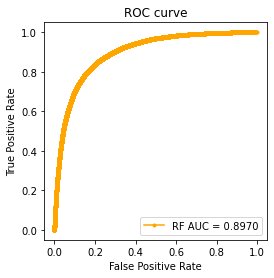

In [21]:
# AUC

rf_auc = roc_auc_score(all_true1, all_p1)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(all_true1, all_p1)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

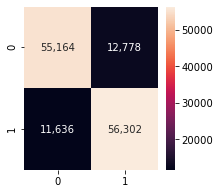

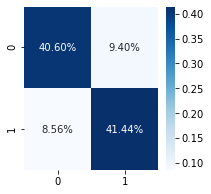

In [23]:
cf_matrix = confusion_matrix(all_true1, all_pred1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [33]:
from torchtext import data, datasets
LABEL = data.Field(sequential=False, use_vocab=False)
TEXT = data.Field(sequential=True, tokenize=tokenizer ,fix_length=45)
pe1,dmp,mp = data.TabularDataset.splits(
        path='compareModel/2021MDPI_CapsNet/', 
    train='pe1.csv',
    validation='dmp.csv',
    test='mp.csv',
    format='csv',
    skip_header=True,
    fields=[('Seqs', TEXT), ('Label', LABEL)])
TEXT.build_vocab(pe1,dmp,mp)
pe1_iter = data.BucketIterator(pe1, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)
dmp_iter = data.BucketIterator(dmp, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)
mp_iter = data.BucketIterator(mp, batch_size=32, sort_key=lambda x: len(x.Seqs), 
                                 shuffle=True,device=DEVICE)

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

In [34]:
all_pred_pe1 = []
all_true_pe1 = []
all_p_pe1 = []

for batch_idx, batch in enumerate(pe1_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p_pe1.extend(list(out1.cpu().detach().numpy()))
    all_pred_pe1.extend(list(y_pre.cpu().detach().numpy()))
    all_true_pe1.extend(list(batch.Label.cpu().detach().numpy()))

/home/bis/miniconda3/envs/torch/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [35]:
all_pred_dmp = []
all_true_dmp = []
all_p_dmp = []

for batch_idx, batch in enumerate(dmp_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p_dmp.extend(list(out1.cpu().detach().numpy()))
    all_pred_dmp.extend(list(y_pre.cpu().detach().numpy()))
    all_true_dmp.extend(list(batch.Label.cpu().detach().numpy()))

In [36]:
all_pred_mp = []
all_true_mp = []
all_p_mp = []

for batch_idx, batch in enumerate(mp_iter):
    data = batch.Seqs
    data = data.permute(1, 0)
    
    out = model(data)
    out = torch.sqrt(torch.sum(out * out, 2))
    out1 = out[:, 1]
    _, y_pre = torch.max(out, -1)
    all_p_mp.extend(list(out1.cpu().detach().numpy()))
    all_pred_mp.extend(list(y_pre.cpu().detach().numpy()))
    all_true_mp.extend(list(batch.Label.cpu().detach().numpy()))

In [32]:
# print(classification_report(all_true_pe1, all_pred_pe1))

# # AUC
# rf_auc = roc_auc_score(all_true_pe1, all_p_pe1)
# print('rf auc : {}'.format(rf_auc))
# # plot the roc curve for the model_high
# rf_fpr, rf_tpr, _ = roc_curve(all_true_pe1, all_p_pe1)
# plt.figure(figsize=(4, 4))
# plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
# plt.title('ROC curve')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()

# cf_matrix = confusion_matrix(all_true_pe1, all_pred_pe1)
# plt.figure(figsize=(3, 3))
# sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
# plt.show()
# plt.figure(figsize=(3, 3))
# sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
#             fmt='.2%', cmap='Blues')
# plt.show()